<!-- ABSTRACT -->

With this script, we apply monte carlo dropout to the trained model and check how well it performs. The result is a plot of the uncertainty of the model's predictions. However, it seems that the uncertainty is not very high.

In [1]:
import os
import sys
import numpy as np
import json
import joblib
import geopandas as gpd
import torch
import tqdm
import help_functions as hf

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from gnn_architecture import MyGnn, mc_dropout_predict
import help_functions as hf

In [2]:
# Paths
run_path = '../../data/runs_01_2025/'
unique_model_description = "1pct_10k/"
districts = gpd.read_file("../../data/visualisation/districts_paris.geojson")
base_case_path = '../../data/links_and_stats/pop_1pct_basecase_average_output_links.geojson'

# Parameters
point_net_conv_layer_structure_local_mlp = "256"
point_net_conv_layer_structure_global_mlp = "512"
gat_conv_layer_structure = "128,256,512,256" 
dropout = 0.3
use_dropout = False
predict_mode_stats = False
in_channels = 5
out_channels = 1
        
run_path = run_path + unique_model_description
data_created_during_training = run_path + 'data_created_during_training/'
links_base_case = gpd.read_file(base_case_path, crs="EPSG:4326")

In [3]:
# Load scalers
scaler_x = joblib.load(data_created_during_training + 'test_x_scaler.pkl')
scaler_pos = joblib.load(data_created_during_training + 'test_pos_scaler.pkl')

# Load the test dataset created during training
test_set_dl = torch.load(data_created_during_training + 'test_dl.pt')

# Load the DataLoader parameters
with open(data_created_during_training + 'test_loader_params.json', 'r') as f:
    test_set_dl_loader_params = json.load(f)
    
# Remove or correct collate_fn if it is incorrectly specified
if 'collate_fn' in test_set_dl_loader_params and isinstance(test_set_dl_loader_params['collate_fn'], str):
    del test_set_dl_loader_params['collate_fn']  # Remove it to use the default collate function
    
test_set_loader = torch.utils.data.DataLoader(test_set_dl, **test_set_dl_loader_params)

In [4]:
point_net_conv_layer_structure_local_mlp = [int(x) for x in point_net_conv_layer_structure_local_mlp.split(',')]
point_net_conv_layer_structure_global_mlp = [int(x) for x in point_net_conv_layer_structure_global_mlp.split(',')]
gat_conv_layer_structure = [int(x) for x in gat_conv_layer_structure.split(',')]

model = MyGnn(in_channels=in_channels, out_channels=out_channels,
              point_net_conv_layer_structure_local_mlp=point_net_conv_layer_structure_local_mlp, 
              point_net_conv_layer_structure_global_mlp = point_net_conv_layer_structure_global_mlp,
              gat_conv_layer_structure=gat_conv_layer_structure,
              dropout=dropout,
              use_dropout=use_dropout,
              predict_mode_stats=predict_mode_stats)

# Load the model state dictionary
model_path = run_path + 'trained_model/model.pth'
model.load_state_dict(torch.load(model_path))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

loss_fct = torch.nn.MSELoss().to(dtype=torch.float32).to(device)

/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model initialized
MyGnn(
  (point_net_conv_1): PointNetConv(local_nn=Sequential(
    (0): Linear(in_features=7, out_features=256, bias=True)
    (1): ReLU()
  ), global_nn=Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
  ))
  (point_net_conv_2): PointNetConv(local_nn=Sequential(
    (0): Linear(in_features=514, out_features=256, bias=True)
    (1): ReLU()
  ), global_nn=Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=128, bias=True)
    (2): ReLU()
  ))
  (read_out_node_predictions): Linear(in_features=64, out_features=1, bias=True)
  (gat_graph_layers): Sequential(
    (0) - TransformerConv(128, 64, heads=4): x, edge_index -> x
    (1) - ReLU(inplace=True): x -> x
    (2) - TransformerConv(256, 128, heads=4): x, edge_index -> x
    (3) - ReLU(inplace=True): x -> x
    (4) - TransformerConv(512, 64, heads=4): x,

In [ ]:
test_loss, r_squared, actual_vals, predictions, baseline_loss = hf.validate_model_on_test_set(model, test_set_loader.dataset, loss_fct, device)

print(f"Test Loss: {test_loss}")
print(f"R-squared: {r_squared}")
print(f"Baseline Loss: {baseline_loss}")

# Next, we will look at single elements of the test set and visualize the performance of the model.


In [ ]:
# DIES KANN EIG AUCH RAUS

fixed_norm_max = 8
i = 0

test_data = test_set_loader.dataset[i]
test_x = test_set_loader.dataset[i].x
test_x = test_x.to('cpu')

test_loss, r_squared, actual_vals, predictions, baseline_loss = hf.validate_model_on_test_set(model, test_data, loss_fct, device)
print(f"Test {i}")
print(f"Test Loss: {test_loss}")
print(f"R-squared: {r_squared}")
print(f"Baseline Loss: {baseline_loss}")

inversed_x = scaler_x.inverse_transform(test_x)

print(f"Length of original_gdf: {len(links_base_case)}")
print(f"Length of inversed_x: {inversed_x.shape[0]}")  # Assuming inversed_x is a numpy array

gdf_with_og_values = hf.data_to_geodataframe_with_og_values(data=test_data, original_gdf=links_base_case, predicted_values=predictions, inversed_x=inversed_x, use_all_features=False)
gdf_with_og_values['capacity_reduction_rounded'] = gdf_with_og_values['capacity_reduction'].round(decimals=3)
gdf_with_og_values['highway'] = gdf_with_og_values['highway'].map(hf.highway_mapping)

hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_change_predicted", 
                        save_it=True, number_to_plot=i, zone_to_plot = "this zone", is_predicted=True, alpha=0, use_fixed_norm=True, 
                        fixed_norm_max = fixed_norm_max,
                        known_districts = False, buffer = 0.0005, districts_of_interest=None)

hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_change_actual", save_it=True, 
                        number_to_plot=i, zone_to_plot = "this zone",is_predicted=False,alpha=10,use_fixed_norm=True, 
                        fixed_norm_max = fixed_norm_max,
                        known_districts = False, buffer = 0.0005, districts_of_interest=None)

In [ ]:
# MC DROPOUT on Single Sample

i = 32
test_data = test_set_loader.dataset[i]
test_x = test_set_loader.dataset[i].x
test_x = test_x.to('cpu')

test_loss, r_squared, actual_vals, predictions, baseline_loss = hf.validate_model_on_test_set(model, test_data, loss_fct, device)
print(f"Test {i}")
print(f"Test Loss: {test_loss}")
print(f"R-squared: {r_squared}")
print(f"Baseline Loss: {baseline_loss}")

inversed_x = scaler_x.inverse_transform(test_x)
mean_predictions, uncertainties = mc_dropout_predict(model, test_data, num_samples=50, device=device)

gdf_with_og_values = hf.data_to_geodataframe_with_og_values(data=test_data, original_gdf=links_base_case, predicted_values=predictions, inversed_x=inversed_x, use_all_features=False)
gdf_with_og_values['capacity_reduction_rounded'] = gdf_with_og_values['capacity_reduction'].round(decimals=3)
gdf_with_og_values['highway'] = gdf_with_og_values['highway'].map(hf.highway_mapping)
gdf_with_og_values['mc_uncertainty'] = uncertainties

hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="mc_uncertainty", plot_contour_lines=False,
                        save_it=True, number_to_plot=i, zone_to_plot = "this zone", is_predicted=True, use_fixed_norm=False,
                        known_districts = False, buffer = 0.0005, districts_of_interest=None, cmap='Reds')

100%|██████████| 416/416 [19:02<00:00,  2.75s/it]


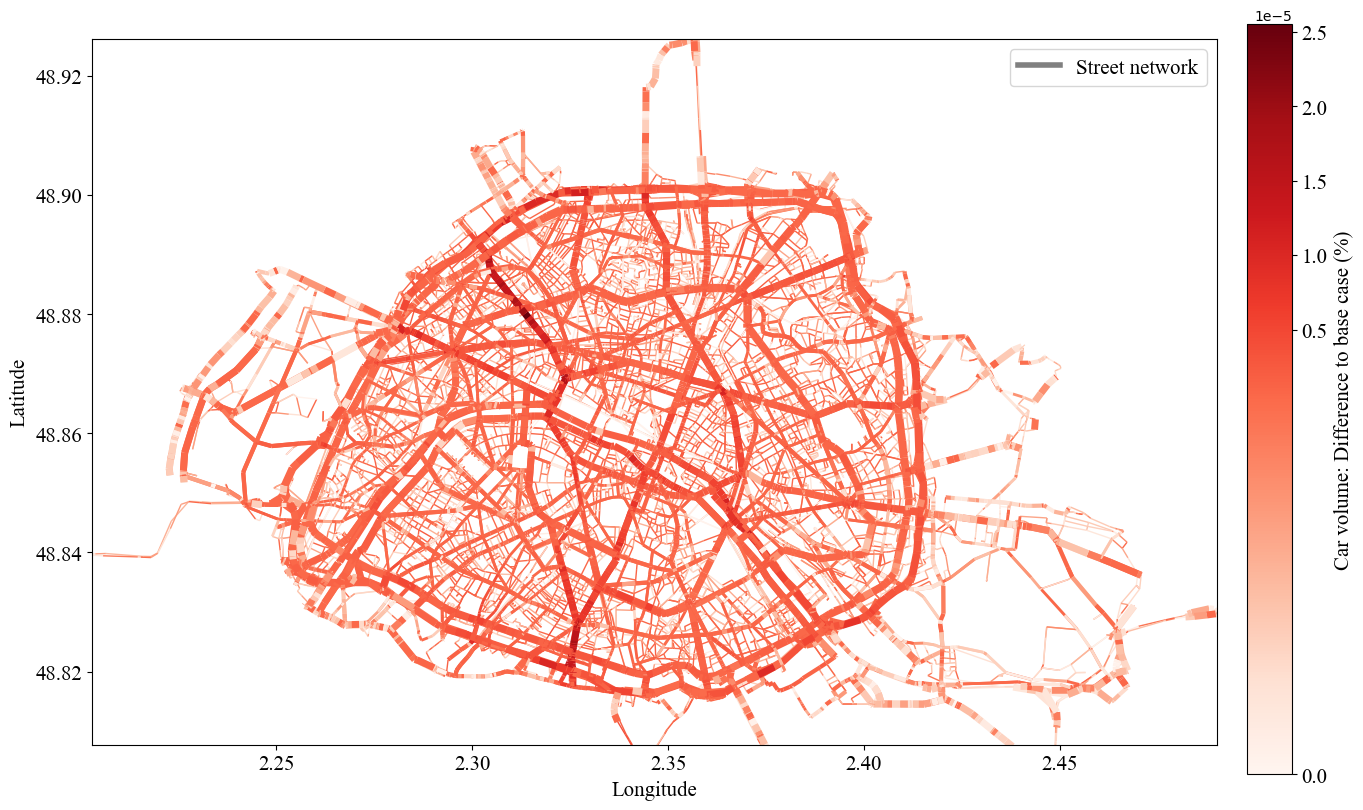

In [7]:
# MC DROPOUT on entire test set

mean_uncertainties = []

for i in tqdm.tqdm(range(len(test_set_loader.dataset))):
    
    test_data = test_set_loader.dataset[i]
    test_x = test_set_loader.dataset[i].x
    test_x = test_x.to('cpu')

    mean_predictions, uncertainties = mc_dropout_predict(model, test_data, num_samples=50, device=device)
    mean_uncertainties.append(uncertainties)

mean_uncertainties = np.array(mean_uncertainties).mean(axis=0)

# On the last sample, but does not matter
inversed_x = scaler_x.inverse_transform(test_x)
gdf_with_og_values = hf.data_to_geodataframe_with_og_values(data=test_data, original_gdf=links_base_case, predicted_values=mean_predictions, inversed_x=inversed_x, use_all_features=False)
gdf_with_og_values['capacity_reduction_rounded'] = gdf_with_og_values['capacity_reduction'].round(decimals=3)
gdf_with_og_values['highway'] = gdf_with_og_values['highway'].map(hf.highway_mapping)
gdf_with_og_values['mc_uncertainty'] = mean_uncertainties

hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="mc_uncertainty", plot_contour_lines=False,
                        save_it=True, number_to_plot=i+1, zone_to_plot = "this zone", is_predicted=True, use_fixed_norm=False,
                        known_districts = False, buffer = 0.0005, districts_of_interest=None, cmap='Reds')